In [1]:
from flash_ansr import FlashANSRDataset, get_path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
MODEL = 'v21.0-60M'

In [3]:
dataset = FlashANSRDataset.from_config(get_path('configs', MODEL, 'dataset_train.yaml'))

Compiling Skeletons: 100%|██████████| 1000/1000 [00:00<00:00, 21317.29it/s]


In [4]:
N_SAMPLES = 2**18
print(f'{N_SAMPLES:,}')

262,144


In [5]:
data_raw = [d for d in dataset.iterate(size=N_SAMPLES, verbose=True, persistent=True, n_per_equation=1, batch_size=1)]

Generating Batches: 100%|██████████| 262144/262144 [01:48<00:00, 2422.86it/s]


In [6]:
data = {k: [d[k] for d in data_raw] for k in data_raw[0].keys()}

In [7]:
data.keys()

dict_keys(['x_tensors', 'y_tensors', 'data_attn_mask', 'input_ids', 'constants', 'skeleton', 'skeleton_hash', 'expression'])

In [ ]:
data['skeleton'] = [[str(token) for token in d[0]] for d in data['skeleton']]
data['expression'] = [[str(token) for token in d[0]] for d in data['expression']]
data['constants'] = [[float(constant) for constant in d[0]] for d in data['constants']]
data['lengths'] = np.array([len(s) for s in data['skeleton']])
data['n_support'] = np.array([(~(s[0] == 0).all(axis=1)).sum() for s in data['x_tensors']])
data['all_x'] = np.array([x.item() for x_tensor in tqdm(data['x_tensors']) for x in x_tensor.flatten()])
data['all_x'] = data['all_x'][data['all_x'] != 0]
data['all_y'] = np.array([y.item() for y_tensor in tqdm(data['y_tensors']) for y in y_tensor.flatten()])
data['all_constants'] = np.array([c for constants in tqdm(data['constants']) for c in constants])
data['n_constants'] = np.array([len(constants) for constants in data['constants']])
data['n_variables'] = np.array([len([token for token in s if token.startswith('x')]) for s in data['skeleton']])
data['n_unique_variables'] = np.array([len(set([token for token in s if token.startswith('x')])) for s in data['skeleton']])

  0%|          | 1288/262144 [00:04<15:37, 278.13it/s]

In [ ]:
def format_int(x):
    if x < 1_000:
        return int(x)
    elif x < 1_000_000:
        return f'{int(x // 1_000)}k' if x % 1_000 == 0 else f'{x / 1_000:.1f}k'
    else:
        return f'{int(x // 1_000_000)}M' if x % 1_000_000 == 0 else f'{x / 1_000_000:.1f}M'

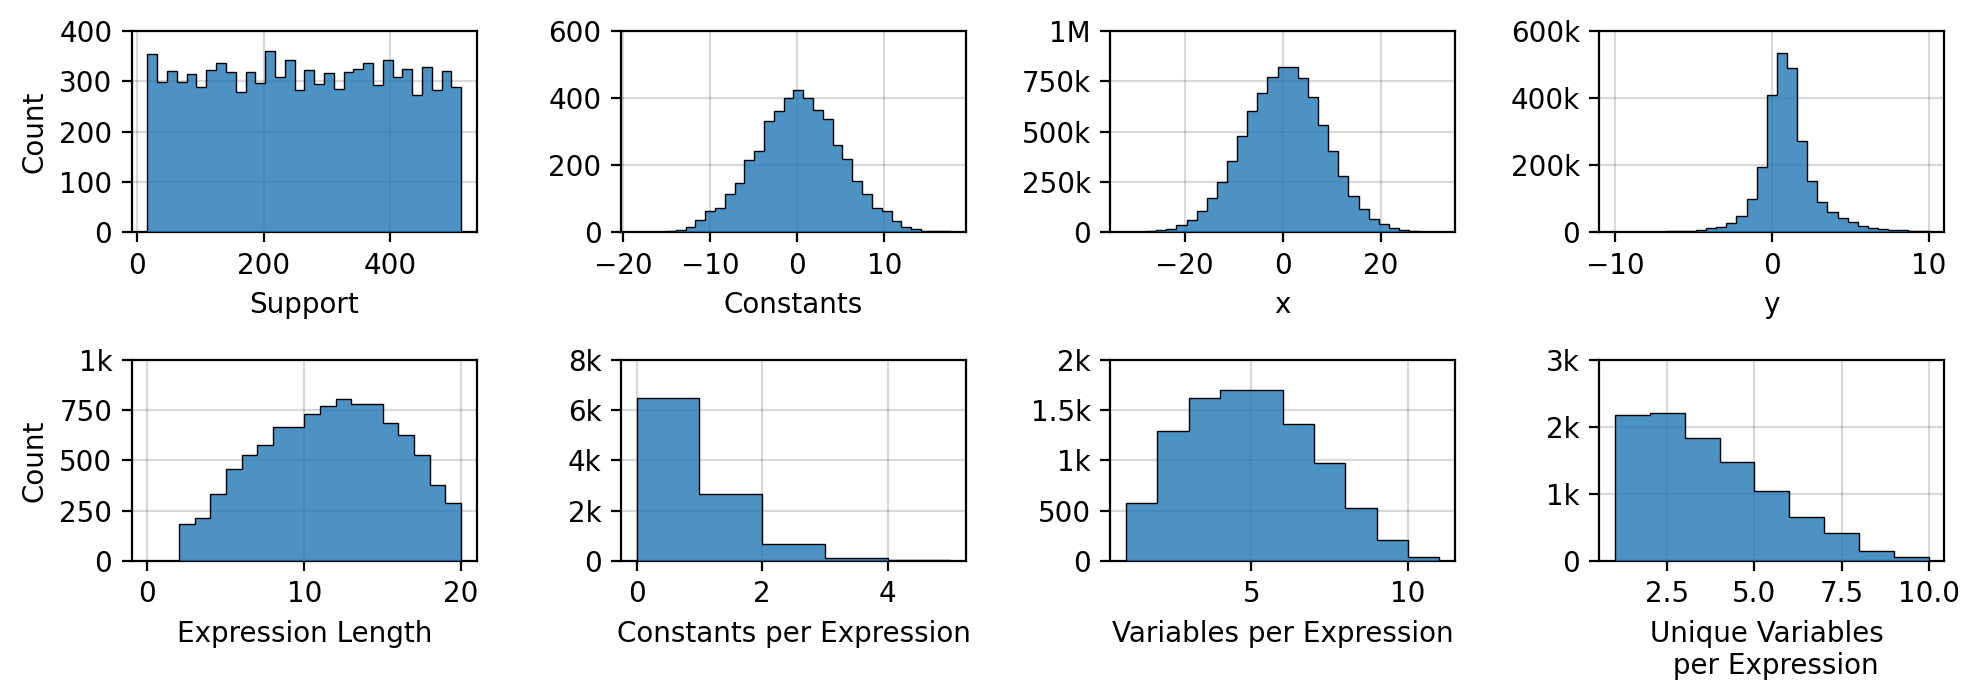

In [ ]:
histogram_keys = ['n_support', 'all_constants', 'all_x', 'all_y', 'lengths', 'n_constants', 'n_variables', 'n_unique_variables']
titles = ['Support', 'Constants', 'x', 'y', 'Expression Length', 'Constants per Expression', 'Variables per Expression', 'Unique Variables \n per Expression']
bins_list = [32, 32, np.linspace(-32, 32, 32), np.linspace(-10, 10, 32), np.arange(0, data['lengths'].max()), np.unique(data['n_constants']), np.unique(data['n_variables']), np.unique(data['n_unique_variables'])]

COLS = min(4, len(histogram_keys))
ROWS = np.ceil(len(histogram_keys) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.8), dpi=200)

for i, (ax, k, bins, title) in enumerate(zip(axes.flatten(), histogram_keys, bins_list, titles)):

    d = data[k]
    if k == 'all_y':
        d = np.log10(np.abs(d[d != 0]))

    ax.hist(d, bins=bins, zorder=4, alpha=0.8, rasterized=True)
    ax.hist(d, bins=bins, zorder=6, histtype='step', edgecolor='k', linewidth=0.5, rasterized=True)
    ax.set_xlabel(title)
    if i % COLS == 0:
        ax.set_ylabel('Count')
    ax.grid(alpha=0.15, color='k')
    # ax.set_xticks(np.arange(0, 20, 5));

    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([format_int(y) for y in ax.get_yticks()])

for ax in axes.flatten()[len(histogram_keys):]:
    ax.set_axis_off()

fig.tight_layout(w_pad=2)

# plt.savefig(get_path('results', 'data_analysis', create=True, filename='data_histograms.svg'), bbox_inches='tight')

In [ ]:
data['skeleton'][6]

['-',
 '-',
 '*',
 'acos',
 'div4',
 'x10',
 'div4',
 '+',
 'x3',
 'x8',
 '/',
 'x10',
 'neg',
 'x1',
 'div5',
 'x2']

In [ ]:
operator_counts = {op: 0 for op in dataset.skeleton_pool.simplipy_engine.operator_arity.keys()}
for skeleton in data['skeleton']:
    for token in skeleton:
        if token in dataset.skeleton_pool.simplipy_engine.operator_arity.keys():
            operator_counts[token] += 1

In [ ]:
variable_counts = {v: 0 for v in dataset.skeleton_pool.variables}
for skeleton in data['skeleton']:
    for token in skeleton:
        if token in dataset.skeleton_pool.variables:
            variable_counts[token] += 1
variable_counts

{'x1': 4507,
 'x2': 4274,
 'x3': 4559,
 'x4': 4587,
 'x5': 4550,
 'x6': 4470,
 'x7': 4537,
 'x8': 4459,
 'x9': 4365,
 'x10': 4474}

In [ ]:
operators_total = sum(operator_counts.values())
normalized_operator_counts = {op: count / operators_total for op, count in operator_counts.items()}
normalized_operator_counts_prior = np.array(list(dataset.skeleton_pool.operator_weights.values())) / sum(dataset.skeleton_pool.operator_weights.values())

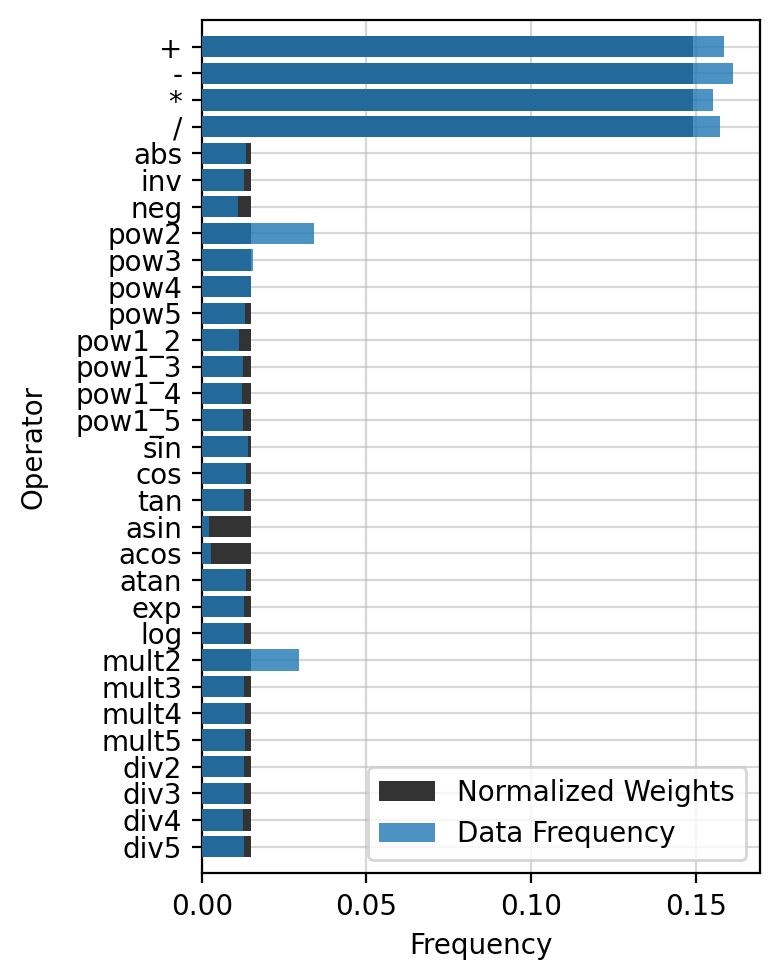

In [ ]:
fig, ax = plt.subplots(figsize=(4, 5), dpi=200)

ax.barh(dataset.skeleton_pool.operator_weights.keys(), normalized_operator_counts_prior, zorder=4, color='#333333', label='Normalized Weights', rasterized=True)
ax.barh(dataset.skeleton_pool.operator_weights.keys(), [normalized_operator_counts[op] for op in dataset.skeleton_pool.operator_weights.keys()], zorder=6, alpha=0.8, label='Data Frequency', rasterized=True)

ax.set_ylim(-1, len(dataset.skeleton_pool.operator_weights))

ax.invert_yaxis()

ax.set_xlabel('Frequency')
ax.set_ylabel('Operator', labelpad=10)
ax.grid(alpha=0.5, zorder=1)

ax.legend()

fig.tight_layout()

# plt.savefig(get_path('results', 'data_analysis', create=True, filename='train_operator_frequencies.svg'), bbox_inches='tight')

In [ ]:
from collections import Counter

In [ ]:
# Most common expressions
counter = Counter([tuple(s) for s in data['skeleton']])

In [ ]:
# Note: various permutations of the same expressions may not be present due to filtering of held-out expressions
for expression, count in counter.most_common(32):
    print(f'{count:>3}: {(expression)}')

  6: ('pow2', 'x8')
  5: ('pow2', 'x4')
  4: ('pow1_3', 'x4')
  4: ('pow3', 'x2')
  4: ('div2', 'x8')
  4: ('pow2', 'x2')
  4: ('+', 'x2', 'pow2', 'x2')
  3: ('div5', 'x9')
  3: ('inv', 'x10')
  3: ('mult3', 'x6')
  3: ('*', 'x2', 'x9')
  3: ('mult3', 'x9')
  3: ('inv', 'x4')
  3: ('mult2', 'x3')
  3: ('mult3', 'x5')
  3: ('neg', 'x4')
  3: ('tan', 'x9')
  3: ('mult4', 'x10')
  3: ('neg', 'x10')
  3: ('mult2', 'pow2', 'x6')
  2: ('mult5', 'x5')
  2: ('pow3', 'x5')
  2: ('div4', 'x10')
  2: ('exp', 'pow1_4', 'x7')
  2: ('inv', 'x6')
  2: ('-', 'x4', 'x6')
  2: ('*', '<constant>', 'pow2', 'x2')
  2: ('pow4', 'x2')
  2: ('inv', 'x3')
  2: ('neg', 'pow2', 'x5')
  2: ('neg', 'x1')
  2: ('mult2', 'x4')


In [ ]:
one_dimensional_x = np.array([np.array(x_tensor)[0] for x_tensor, n_unique_variables in zip(data['x_tensors'], data['n_unique_variables']) if n_unique_variables == 1])
one_dimensional_x = np.array([x[:, np.where((~(x == 0).all(axis=0)))[0][0]].flatten() for x in one_dimensional_x])

one_dimensional_y = np.array([np.array(y_tensor).flatten() for y_tensor, n_unique_variables in zip(data['y_tensors'], data['n_unique_variables']) if n_unique_variables == 1])

print(one_dimensional_x.shape, one_dimensional_y.shape)

one_dimensional_x = np.concatenate(one_dimensional_x)
one_dimensional_y = np.concatenate(one_dimensional_y)

print(one_dimensional_x.shape, one_dimensional_y.shape)

(2177, 512) (2177, 512)
(1114624,) (1114624,)


/tmp/ipykernel_2803/3825786293.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  one_dimensional_x = np.array([np.array(x_tensor)[0] for x_tensor, n_unique_variables in zip(data['x_tensors'], data['n_unique_variables']) if n_unique_variables == 1])
/tmp/ipykernel_2803/3825786293.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  one_dimensional_y = np.array([np.array(y_tensor).flatten() for y_tensor, n_unique_variables in zip(data['y_tensors'], data['n_unique_variables']

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.5) + (1.0,)

(np.float64(0.133502), np.float64(0.002437), np.float64(0.1647075), 1.0)

In [ ]:
one_dimensional_x.shape,one_dimensional_y.shape

((1114624,), (1114624,))

/tmp/ipykernel_2803/3258403792.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


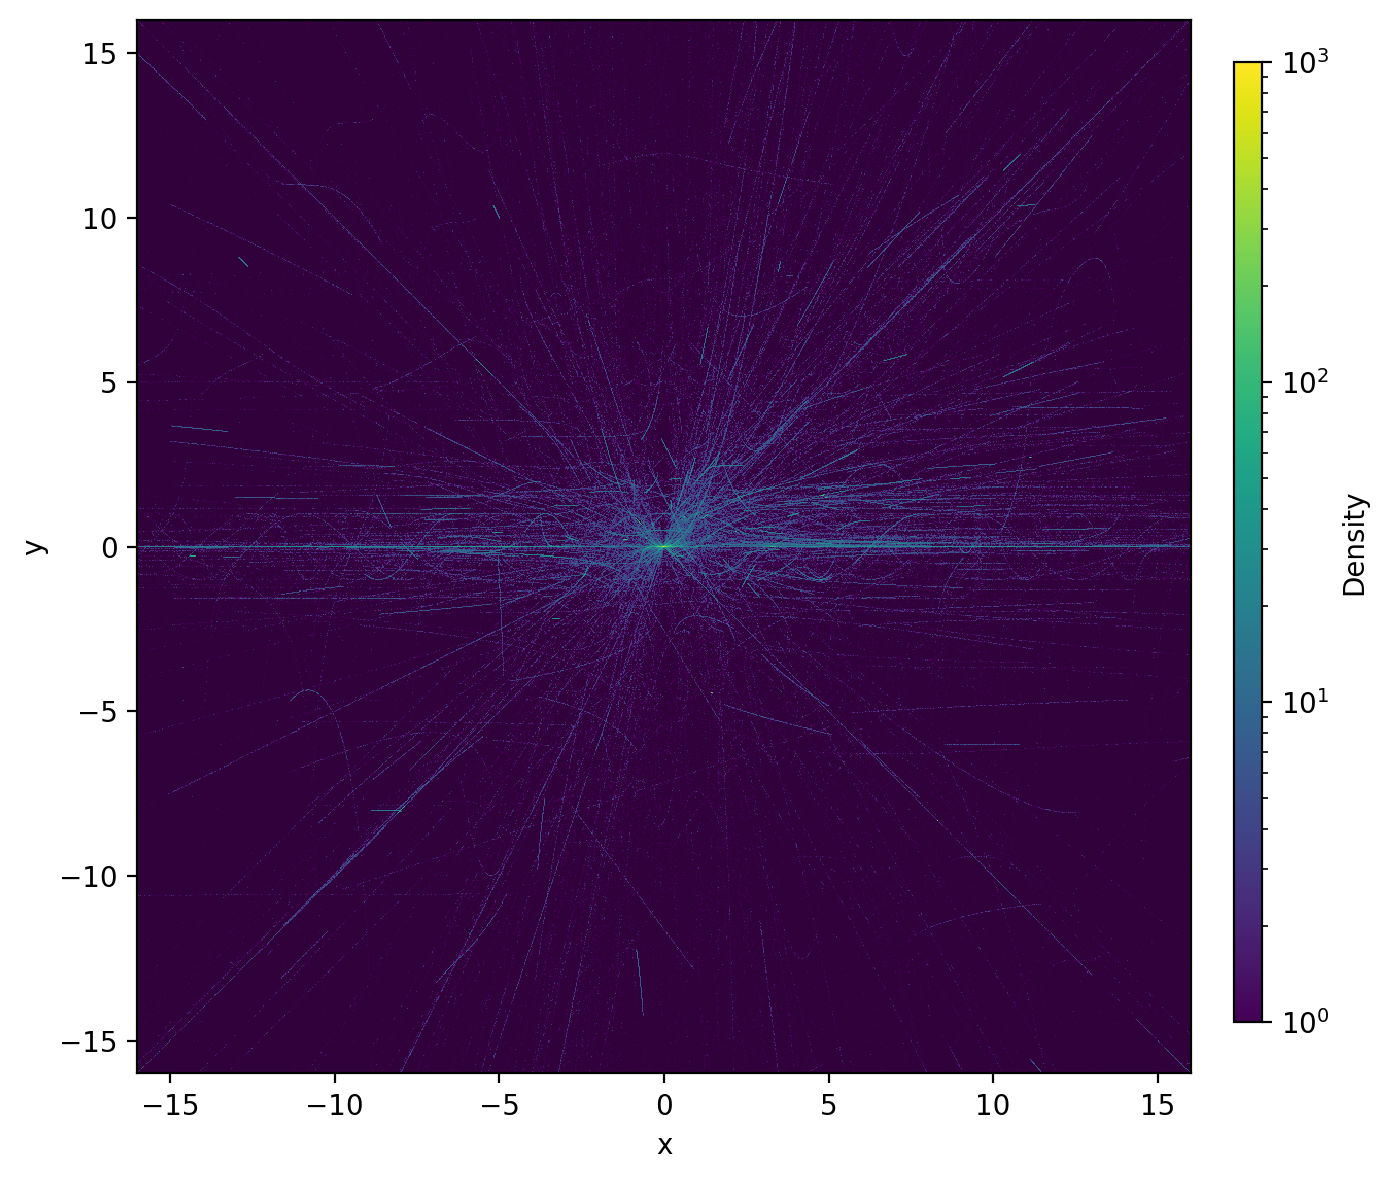

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=200)

# Change the fontsize
plt.rcParams.update({'font.size': 10})

res = 512
lim = 16
img = ax.hist2d(one_dimensional_x, one_dimensional_y, bins=(np.linspace(-lim, lim, res*2), np.linspace(-lim, lim, res*2)), norm=LogNorm(vmin=1, vmax=1e3), rasterized=True);
ax.set_facecolor(tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.7) + (1,))

ax.set_aspect('equal')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.80])
fig.colorbar(img[3], cax=cbar_ax, label='Density')

fig.tight_layout()

# plt.savefig(get_path('results', 'data_analysis', create=True, filename='1d_train_superimposed.svg'), bbox_inches='tight')